# Final Report and Summary of Analysis - King County Housing Sale Prices

### CONTENTS

- I. Purpose
- II. Model Creation
    1. Importing
    2. First Simple Model
        - Square Footage Analysis
    3. Investigate Claims
        - a. Porch
        - b. Waterfront
        - c. Nuisance
    4. Feature adding
        - a. Porch
        - b. Waterfront
        - c. Nuisance
- III. Recommendations for Real World Application
- IV. Next Steps

# I. Purpose
This project is aimed to help homeowners and potential homeowners in King County understand how specific features affect home sale prices in the area. The data we will use can be downloaded from here: 
https://info.kingcounty.gov/assessor/DataDownload/default.aspx.
Through our analysis our end goal is to build a statistical model that is representative of the real world data. 

In summary, the report that follows addresses following questions:

    1. How does higher square footage increase home sale price?
    2. How does having a porch increases home sale price?
    3. How does having a waterfront increase home sale prices?
    4. How does the presence of a nuisance (power lines, traffic noise, airport noise) lower home sale prices?
    5. Using this data, can a statistical model be built that accurately represents housing prices in King County?

# II. Model Creation

### Summary of Workflow
1. Clean and filter data
 - Filtered out data irrelevent to 2019 Residential Home Sales (cut out commercial buildings, sales before or afte 2019, etc.)
 - Added PIN Column to each filtered data set, enabling all datasets to be joined according to specific pieces of property.
2. Build First Simple Model
 - We found that total square footage had the strongest and clearest correlation, so this became our first feature.
 a. Examine Linear Regression Assumptions. If assumptions not met, perform neccessary transformations and re-examine assumptions.
3. Investigate claims
 - Did preliminary research into the effects certain features have on sale price.
 - These claims provide the basis for which features we wish to add to the model.
4. Add a feature
 - Add one feature and evaluate the effect it has on the model.
 a. Examine Linear Regression Assumptions. If assumptions not met, perform neccessary transformations and re-examine assumptions.
5. Repeat steps 3 and 4 for any feature that may improve performance

# 1. Clean and Filter Data

Using Pandas we created a series of filters through which we removed data that did not fit into the scope of this project. Here is a description of each filter we created:
- A. Property that was sold in 2019, to see the factors that affect the current market.

- B. Property that was sold, as opposed to foreclosed or transferred as part of a settlement.

- C. Property that is residential, as opposed to commercial.

- D. Property that was not 'sold' for a value of zero dollars, as these represent sales circumstances such as inheritance, which does not provide accurate portrayal of a property's value.

- E. Property that has one building on a given tax parcel. Our data does not include an accurate way to differentiate the values for multiple homes on a single parcel, so these will be excluded to maintain accuracy.

- F. Property that is not a mansion, simply because first time homebuyers are likely not investing in  mansions.

Upon filtering the data, we exported each data set under the same name as its original file with the suffix '_final' added on. For example, the filtering process takes in the 'EXTR_RPSale.csv' file and exports a filtered version called 'EXTR_RPSale_final.csv'. The notebook titled '00_mef_initial_data_cleaning.ipynb' must be run into order to create all necessary files for this project; make sure you run that notebook before continuing.

In [1]:
import pandas as pd
data_folder = '../../data/'

sales = pd.read_csv(data_folder+'EXTR_RPSale_final.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})
parcels = pd.read_csv(data_folder+'EXTR_Parcel_final.csv',dtype={'Major': 'string', 'Minor':'string', 'PIN': 'string'})
res_bldg = pd.read_csv(data_folder+'EXTR_ResBldg_final.csv', dtype={'Major':'string', 'Minor':'string', 'PIN':'string'})

# 2. Build First Simple Model
### Choosing the first feature
For our baseline model, we wanted to find a single feature that will most closely correlate with home sale value. In order to do this, we examined the correlations of a variety of features and chose the strongest one.

The functions found in our cm_functions module allow us to visualize these correlations quickly.

POSITIVE CORRELATIONS:
      SalePrice   BldgGrade   0.5916954575888591
      SalePrice   SqFtTotLiving   0.6001157952961085
NEGATIVE CORRELATIONS:


(['BldgGrade', 'SqFtTotLiving'], [])

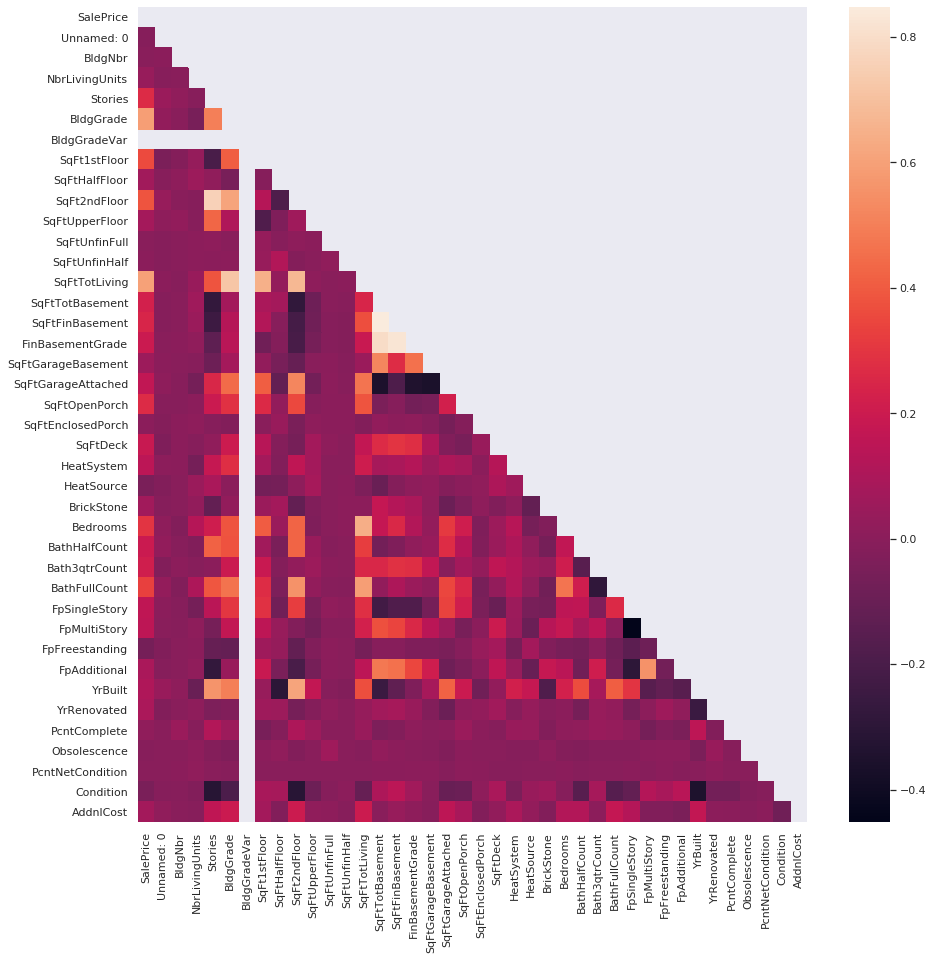

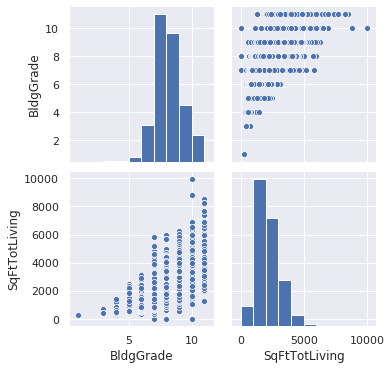

In [2]:
#let's add the project directory to our module path
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    

#import the cm_functions module from our src folder
from src import cm_functions
# import scipy.stats and numpy for outlier removal
from scipy import stats
import numpy as np


# merge our sales and res_bldg data
sales_and_res = pd.merge(sales.loc[:,['SalePrice', 'PIN']], res_bldg, on='PIN', how='inner')
# remove outliers 
z = np.abs(stats.zscore(sales_and_res.SalePrice))
sales_and_res = sales_and_res[z < 3]

cm_functions.df_corr(sales_and_res, .5)

## Feature selection:
The heatmap above is composed of a grid where the interesection of each feature is assigned a color representing the correlation between them. For the purposes of this investigation, we will focus on the first column, labeled SalePrice, and we will search that column for the lightest colors for any positive correlations. The list just above the heatmap lists the positive correlation coefficients associated with the feature with the highest correlation:
- Building Grade (BldgGrade)
- Square Foot Living Space (SqFtTotLiving)

The third plot examines the correlation between these three features to examine whether there is a relationship between them. Linear Regression suffers when it uses features that are correlated with each other. In other words, our model want features that are completely unrelated. The correlation found between building grade and square foot living space means that the predicitve abilities of our model may suffer if both features are used. For this reason, we had to drop one of the features. we chose to drop Building Grade because we did not have access to how building grade was measure, so any findings based on that would be difficult to communicate.

### Square Footage - Analysis
In order to determine the efficacy of Square Foot Living Space as a potential feature, we wanted take a look at what the correlation looks like. In order to do this we created the following graph.

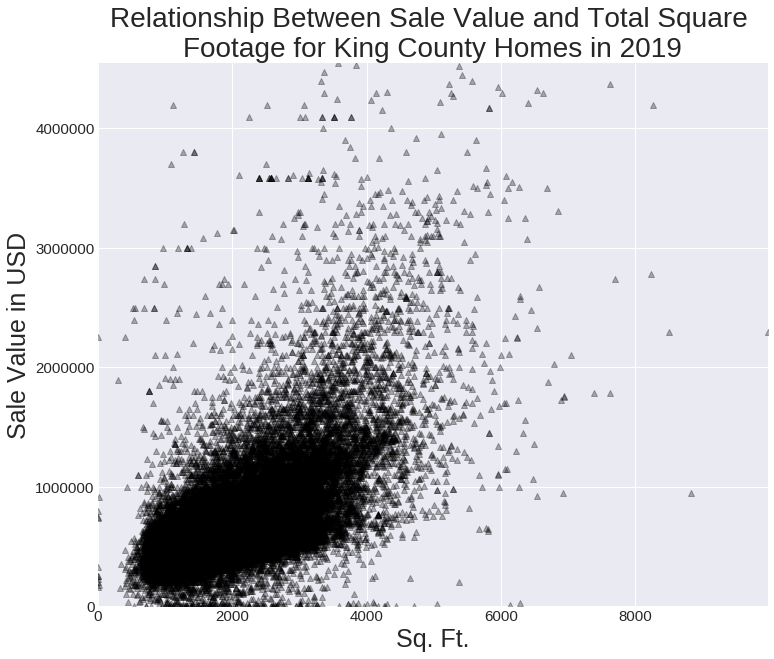

In [3]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')

# format
x = sales_and_res.SqFtTotLiving
y = sales_and_res.SalePrice
xmin = 0
xmax = x.max()
ymin = 0
ymax = y.max()

fig, ax = plt.subplots(1,1 , sharey=True, figsize=(12, 10))


ax.scatter(x, y, marker='^', alpha=.3, c='black')
ax.axis([xmin, xmax, ymin, ymax])
ax.plot()

#set text
ax.set_title("Relationship Between Sale Value and Total Square \nFootage for King County Homes in 2019", fontsize=28)
ax.set_xlabel('Sq. Ft.', fontsize = 25)
ax.set_ylabel('Sale Value in USD', fontsize = 25)
ax.tick_params(labelsize=15)

### First Simple Model Creation
Using this as our first feature, we created our initial model. 

In [4]:
model_data = sales_and_res.loc[:,['SalePrice', 'SqFtTotLiving']]
fsm = cm_functions.get_fsm(model_data)

Rsquared: 0.360138967763874
BETA values:
Intercept        88833.499924
SqFtTotLiving      317.224094
dtype: float64
------------------------------------
 
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                 1.602e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:59:32   Log-Likelihood:            -4.0713e+05
No. Observations:               28470   AIC:                         8.143e+05
Df Residuals:                   28468   BIC:                         8.143e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|

We can visualize this model using the intercept and the feature coefficient:

findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans.


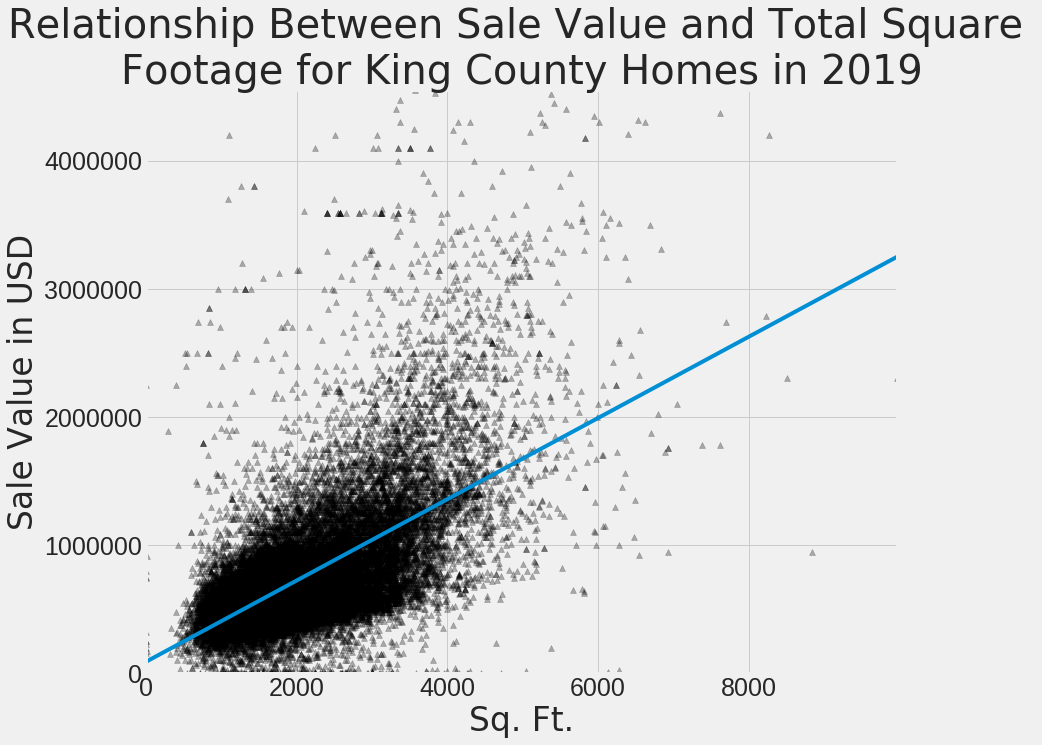

In [5]:
#line
b = 88830
m = 317.22

minimum = sales_and_res.SalePrice.min()
maximum =  sales_and_res.SalePrice.max()

x_line = np.linspace(minimum, maximum, 100)
y_line = m*x_line+b

plt.style.use('fivethirtyeight')

# format
x = sales_and_res.SqFtTotLiving
y = sales_and_res.SalePrice
xmin = 0
xmax = x.max()
ymin = 0
ymax = y.max()

fig, ax = plt.subplots(1,1 , sharey=True, figsize=(12, 10))


ax.scatter(x, y, marker='^', alpha=.3, c='#000000')
ax.axis([xmin, xmax, ymin, ymax])
ax.plot(x_line, y_line)

#set text
ax.set_title("Relationship Between Sale Value and Total Square \nFootage for King County Homes in 2019", fontsize=40, fontname="Gill Sans MT")
ax.set_xlabel('Sq. Ft.', fontsize = 33, fontname="Gill Sans MT")
ax.set_ylabel('Sale Value in USD', fontsize = 33, fontname="Gill Sans MT")
ax.tick_params(labelsize=25)

## Takeaways
The intercept value of 88833.49 indicates that you can expect to pay a minimum of about `$88,000` for a home. The coefficient for Square Foot Living Space, 317.22, also indicates that you can expect to pay about `$300` per square foot for a home

### Model Assessment

A successful linear regression model should not violate the following assumptions: 
1. Linearity 
2. Error Independence
3. Normality of Errors
4. Homoscedasticity
5. Multicollinearity (for multiple variable linear regression)

##### 1. Linearity: 
The first assumption for regression is that the target variable and the features have a linear relationship. One can visually confirm this with the scatter plot or look at the rainbow statistic for a qualitative test. 

In [6]:
cm_functions.lr_linear(fsm)

Rainbow statistic: 1.0154181402773679
Rainbow p-value: 0.18069977364372747


(1.0154181402773679, 0.18069977364372747)

Returning a low p-value means that the current model violates the linearity assumption. Because the p-value here is above a standard alpha level we can say that this model does NOT violate linearity assumption. 

##### 2. Error Independence: 
We want to make sure our errors are independent or random and don't influence each other. It is possible to check this qualitatively with a Q-Q plot. 

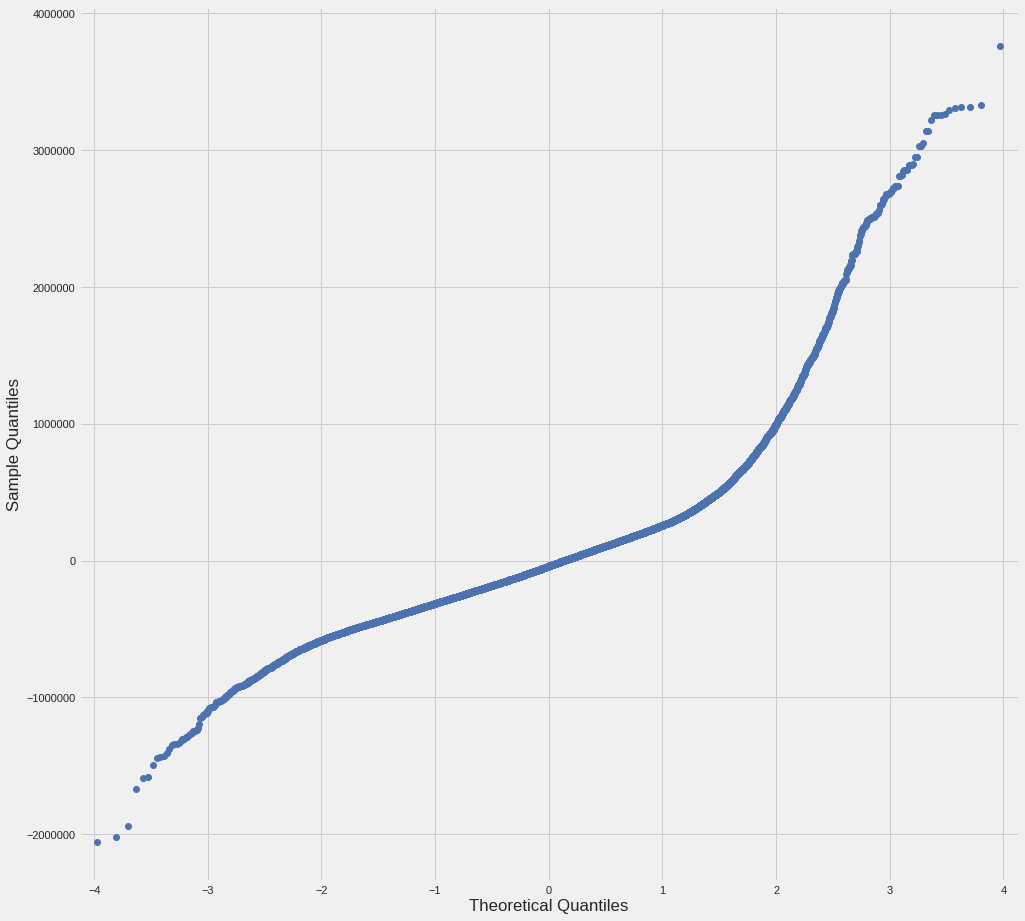

In [7]:
cm_functions.lr_qq(fsm)

Because of the curvature of the qq data plot, we cannot assume error independence. This model violates this assumtion.

##### 3. Normality of Errors
Linear regression assumes that the residuals are normally distributed.The quantitative Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB). 

* Jarque-Bera (JB):           162065.192
* Prob(JB):                         0.00

The null hypothesis for the test is that the data is normally distributed; the alternate hypothesis is that the data does not come from a normal distribution. 

##### 4. Homoscedasticity
We want to make sure that the variance of our residuals is the same across our data. A scatter plot of the residuals along the fitted data in order to visually indicate how homoscedastic our residuals are. 

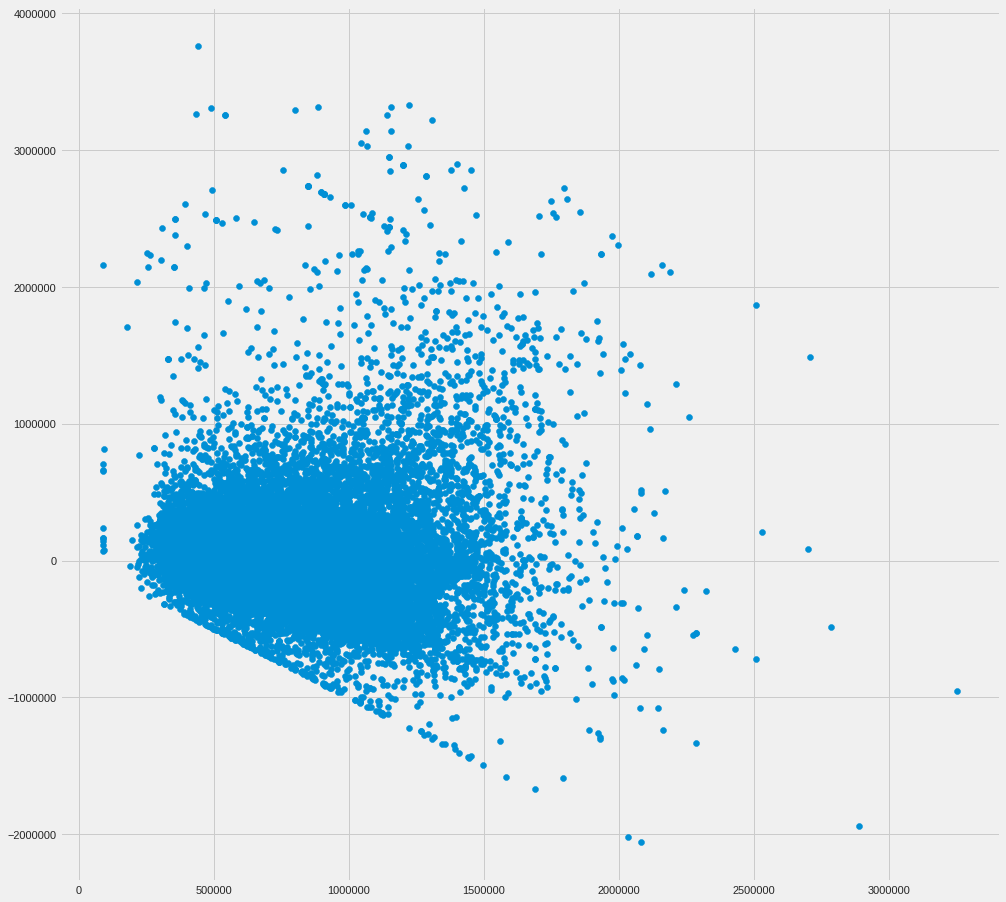

In [8]:
cm_functions.lr_homoscad(fsm, model_data)

We see that our plot is clustered and the variance is not homogeneous across our data. This assumption is violated.

##### 5.	Multicollinearity
This assumption is that the independent variables must not be too collinear. Using a VIF computation we can test this assumption. We have only one independent variable here, we do not need to check this.

# 3. Investigate Claims

## a. Porch
### Findings
From this figure we can see there is about a 200,000 difference in home Sale Price when a home has a porch addition. Showing houses with a porch on average have a higher over all value.

findfont: Font family ['Gill Sans'] not found. Falling back to DejaVu Sans.


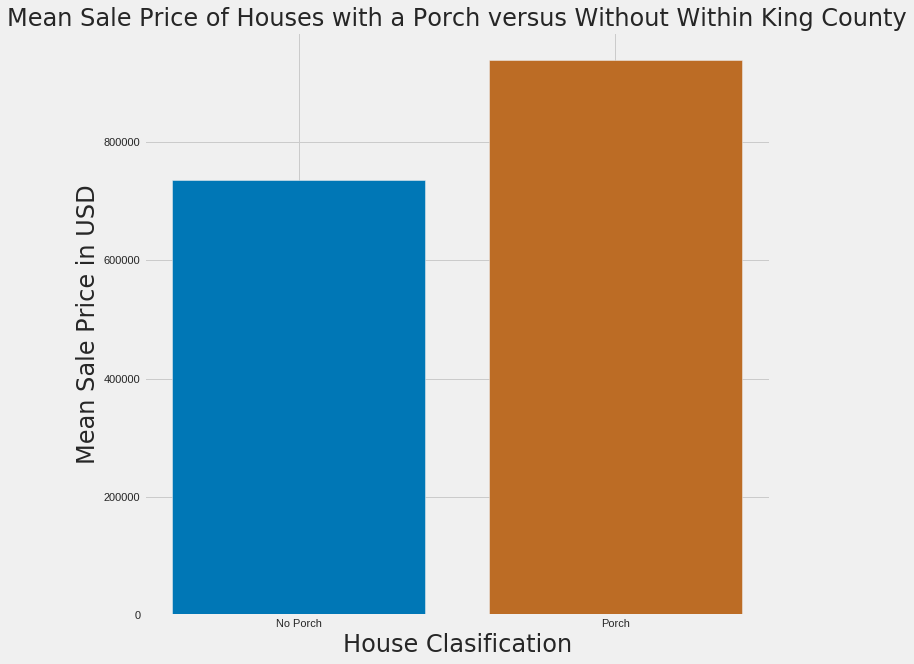

In [9]:
# If either column had a value greater than zero then the residence contained a porch.
has_porch= res_bldg[(res_bldg["SqFtOpenPorch"]!=0)|(res_bldg["SqFtEnclosedPorch"]!=0)]
has_porch

no_porch= res_bldg[(res_bldg["SqFtOpenPorch"]==0)&(res_bldg["SqFtEnclosedPorch"]==0)]
no_porch

## To get our sales price values for each data Frame porch and non-porch we must join them
sales_and_porch=sales.merge(has_porch, how="inner", on="PIN")
sales_and_porch

sales_and_no_porch=sales.merge(no_porch, how="inner", on="PIN")
sales_and_no_porch

### Now we will graph our means to get a visual of the difference between our groups. 

plt.figure(figsize=(10,10))
plt.bar(x=["No Porch","Porch"],
        height=[sales_and_no_porch.SalePrice.mean(), sales_and_porch.SalePrice.mean()],
        color=["#0077b6", "#BC6C25"],);
plt.ylabel('Mean Sale Price in USD', fontsize=24,fontname="Gill Sans")
plt.title('Mean Sale Price of Houses with a Porch versus Without Within King County', fontsize=24,fontname="Gill Sans")
plt.xlabel('House Clasification', fontsize=24,fontname="Gill Sans")
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.show()

For a breakdown on how we created this graph, check out the porch analysis notebook.

In [10]:
sales_and_no_porch

,Unnamed: 0_x,ExciseTaxNbr,Major_x,Minor_x,DocumentDate,SalePrice,RecordingNbr,Volume,Page,PlatNbr,...,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition,AddnlCost
0,3,3015264,124550,0098,2019-09-27,193000,20191015000395,,,,...,1,0,0,1980,0,0,0,0,3,0
1,4,2980648,797320,2320,2019-03-27,540000,,,,,...,0,0,0,1930,0,0,0,0,5,0
2,5,2980836,937630,0695,2019-03-28,550000,20190404001008,,,,...,1,0,0,1985,0,0,0,0,3,0
3,6,3006119,327585,0290,2019-08-13,1025000,20190821000972,,,,...,1,0,0,1989,0,0,0,0,4,0
4,8,2982060,347050,0040,2019-04-04,648500,,,,,...,0,0,0,2005,0,0,0,0,3,6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12766,28610,3020975,692960,2340,2019-11-14,339000,20191115001539,,,,...,0,0,0,1978,0,0,0,0,4,0
12767,28611,3006389,322607,9085,2019-08-20,828130,,,,,...,0,0,0,1989,0,0,0,0,3,0
12768,28612,2992253,010050,0270,2019-06-03,395000,20190607000102,,,,...,0,0,0,1994,0,0,0,0,4,0
12769,28615,2992593,405940,0095,2019-05-21,442000,20190607001670,,,,...,0,0,0,1944,0,0,0,0,4,0


## b. Waterfront

### Findings
The boxplot below shows that in 2019 homes that had a waterfront had a median value of about $342,500.00 higher than homes that did not have one. For a breakdown and step by step process on how we created this plot, check out the waterfront analysis notebook.

In [11]:
srp_df = pd.merge(sales_and_res, parcels, on='PIN', how='inner', suffixes=('_sales', '_res'))
srp_df['is_waterfront'] = (srp_df['WfntLocation'] != 0).astype('int')
cat_dict = {0:'NOT WATERFRONT',1:'WATERFRONT'}
srp_df['is_waterfront'] = pd.Categorical(srp_df['is_waterfront'].map(cat_dict))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


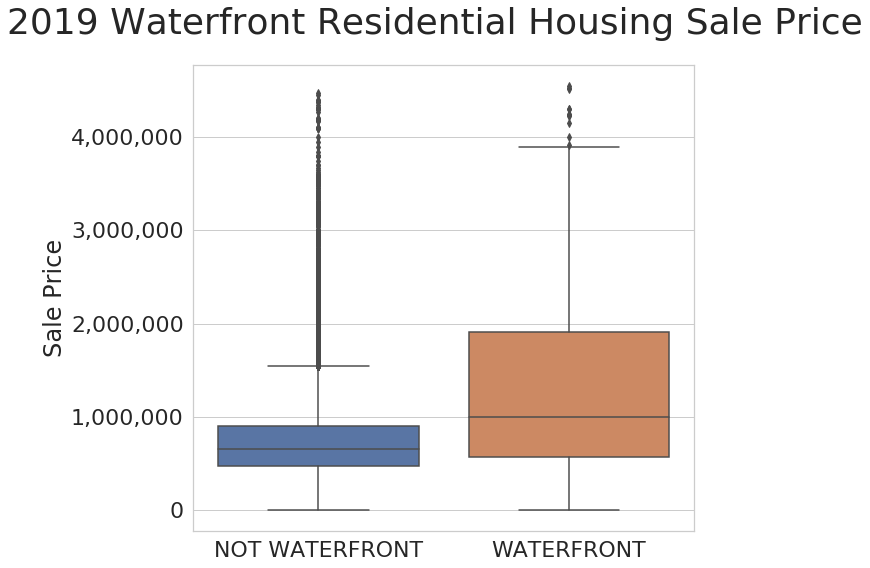

In [12]:
import matplotlib as mpl
import matplotlib.pylab as pylab
import seaborn as sns
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)
sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
sns.set(font_scale=2)
sns.set_style("whitegrid")
is_wfnt_labels = srp_df['is_waterfront'].unique()
fig = plt.figure(figsize=(8, 8))
axes = fig.add_subplot(111)

is_wfnt_boxplot = sns.boxplot(x=srp_df["is_waterfront"], y=srp_df["SalePrice"], data=srp_df,  ax=axes).set(
    xlabel=None, 
    ylabel='Sale Price'
)

fig.suptitle('2019 Waterfront Residential Housing Sale Price', fontsize=36)
sns.set_style({'font.family':'Gill Sans MT', 'font.sans-serif':['Gill Sans']})
axes.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))
sns.reset_orig;

For a breakdown on how we created this graph, check out the porch analysis notebook.

## c. Nuisances
### Findings
The graph below shows that homes that do not suffer from power line nuisances are worth $96393.27 more than homes that do suffer from power line nuisances.

findfont: Font family ['Gill Sans MT'] not found. Falling back to DejaVu Sans.


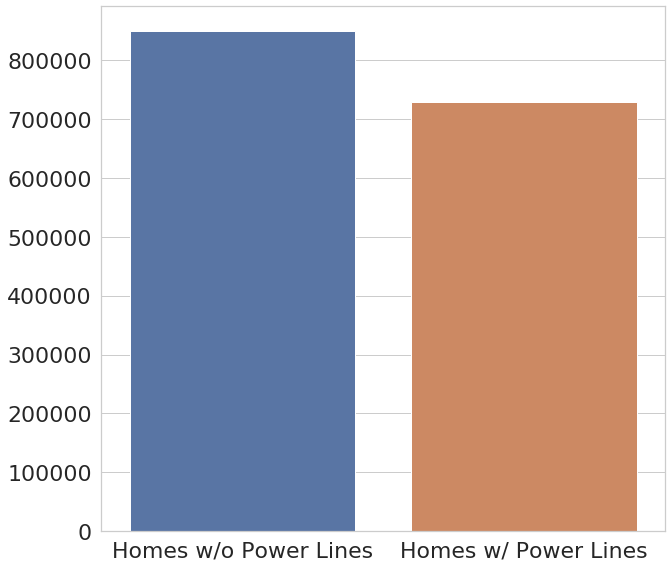

In [13]:
import seaborn as sns
sns.reset_orig
# merge relevant data
sale_and_parcel = pd.merge(sales, parcels, on='PIN', how='inner')
#subset data into groups based on feature
power_lines = sale_and_parcel[sale_and_parcel.PowerLines=='Y']
no_power_lines = sale_and_parcel[sale_and_parcel.PowerLines=='N']
# claculate mean
power_lines_mean = power_lines.SalePrice.mean()
no_power_lines_mean = no_power_lines.SalePrice.mean()
#plot
fig, ax = plt.subplots(1,1,figsize=(9,9))

sns.barplot(x=['Homes w/o Power Lines', 'Homes w/ Power Lines'],y=[no_power_lines_mean, power_lines_mean], ax=ax);

Other nuisances were found to have a far smaller effect on sale price. For instance, traffice noise had very little effect:

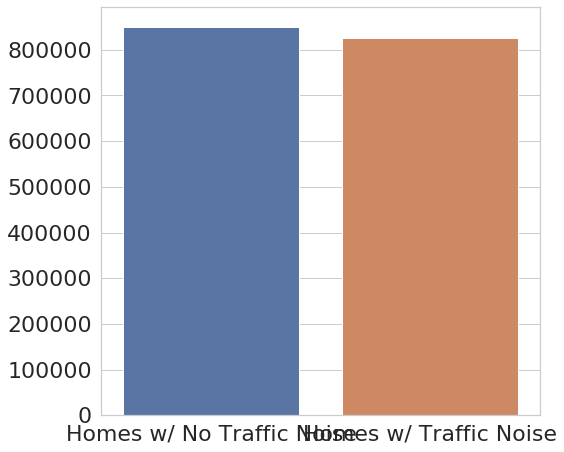

In [14]:
no_traffic = sale_and_parcel[sale_and_parcel['TrafficNoise']==0]
traffic = sale_and_parcel[sale_and_parcel['TrafficNoise']>0]

traffic_mean = traffic.SalePrice.mean()
no_traffic_mean = no_traffic.SalePrice.mean()

fig, ax = plt.subplots(1,1,figsize=(7,7))

sns.barplot(x=['Homes w/ No Traffic Noise', 'Homes w/ Traffic Noise'],y=[no_traffic_mean, traffic_mean], ax=ax);

# 4. Final Model

Normalizing the Sales Data
Based on the distribution plot we recieved after the final filter was applied, we are still not operating on a normal distribution. The following steps will be performed here simply as a means of demonstrating the process that will be used with each iteration of our model testing.
We will log-transform the sales data and along with the non-binary independent variables assign those values to their own respective columns:

In [15]:
sales['LogSalePrice'] = np.log(sales.SalePrice)
res_bldg['PorchTotal'] = res_bldg['SqFtOpenPorch'] + res_bldg['SqFtEnclosedPorch']
res_bldg['LogPorchTotal'] = np.log(pd.DataFrame(res_bldg.loc[res_bldg['PorchTotal']!=0, 'PorchTotal']))
res_bldg.LogPorchTotal.fillna(0)
res_bldg['LogSqFtTotLiving'] = np.log(res_bldg['SqFtTotLiving'])
log_res_df = res_bldg[['LogSqFtTotLiving','SqFtTotLiving','LogPorchTotal','PorchTotal','PIN']]
fm_df = pd.merge(sales, log_res_df, on='PIN', how='inner', suffixes=('_sales', '_res'))

In [16]:
parcels['is_waterfront'] = (parcels['WfntLocation'] != 0).astype('int')

In [17]:
fm_df = pd.merge(fm_df, parcels, on='PIN', how='inner', suffixes=('_sales', '_res'))


In [18]:
fm_df['LogPorchTotal'] = fm_df.LogPorchTotal.fillna(0)

Remove outliers

In [19]:
z = np.abs(stats.zscore(fm_df.LogSalePrice))
fm_df = fm_df[z < 3]

POSITIVE CORRELATIONS:
      LogSalePrice   LogSqFtTotLiving   0.561262510478704
      LogSalePrice   LogPorchTotal   0.25079188348798737
      LogSalePrice   is_waterfront   0.11151816996600808
NEGATIVE CORRELATIONS:


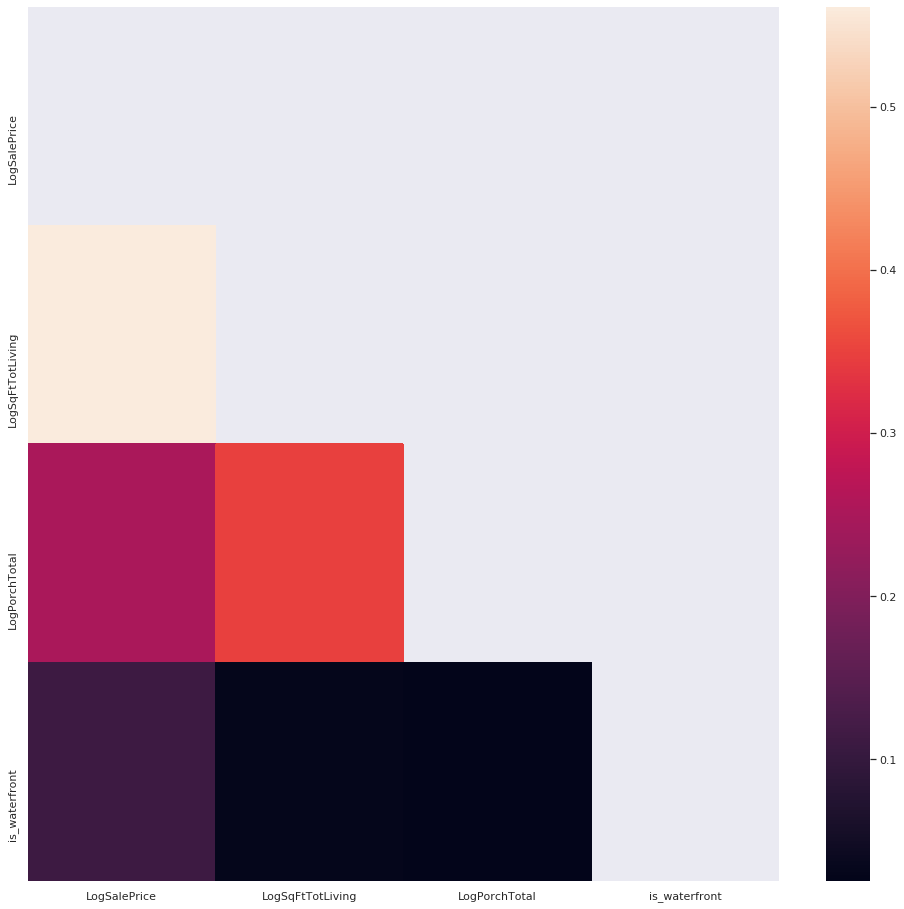

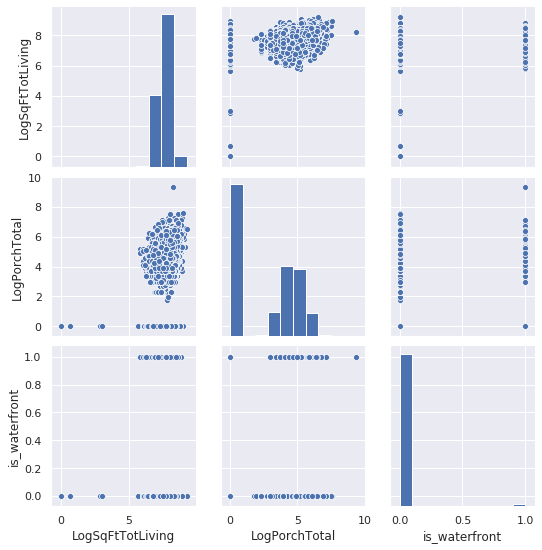

In [20]:
fmodel_df = fm_df.loc[:, ['LogSalePrice', 'LogSqFtTotLiving', 'LogPorchTotal','is_waterfront']]
pos, neg = cm_functions.df_corr(fmodel_df,.1)

In [21]:
fm = cm_functions.get_fsm(fmodel_df)

Rsquared: 0.32719120922150946
BETA values:
Intercept           8.638013
LogSqFtTotLiving    0.625482
LogPorchTotal       0.013364
is_waterfront       0.415389
dtype: float64
------------------------------------
 
                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     4580.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        08:59:44   Log-Likelihood:                -16380.
No. Observations:               28256   AIC:                         3.277e+04
Df Residuals:                   28252   BIC:                         3.280e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                       

1. Linearity:

In [22]:
cm_functions.lr_linear(fm)

Rainbow statistic: 0.96499074782796
Rainbow p-value: 0.9828986831366505


(0.96499074782796, 0.9828986831366505)

The null hypothesis is that the model is linear, alternative hypothesis is that it is not. Because our p-value is  not below the standard alpha level, the current model does not violate the linearity assumption.

##### 2. Error Independence: 

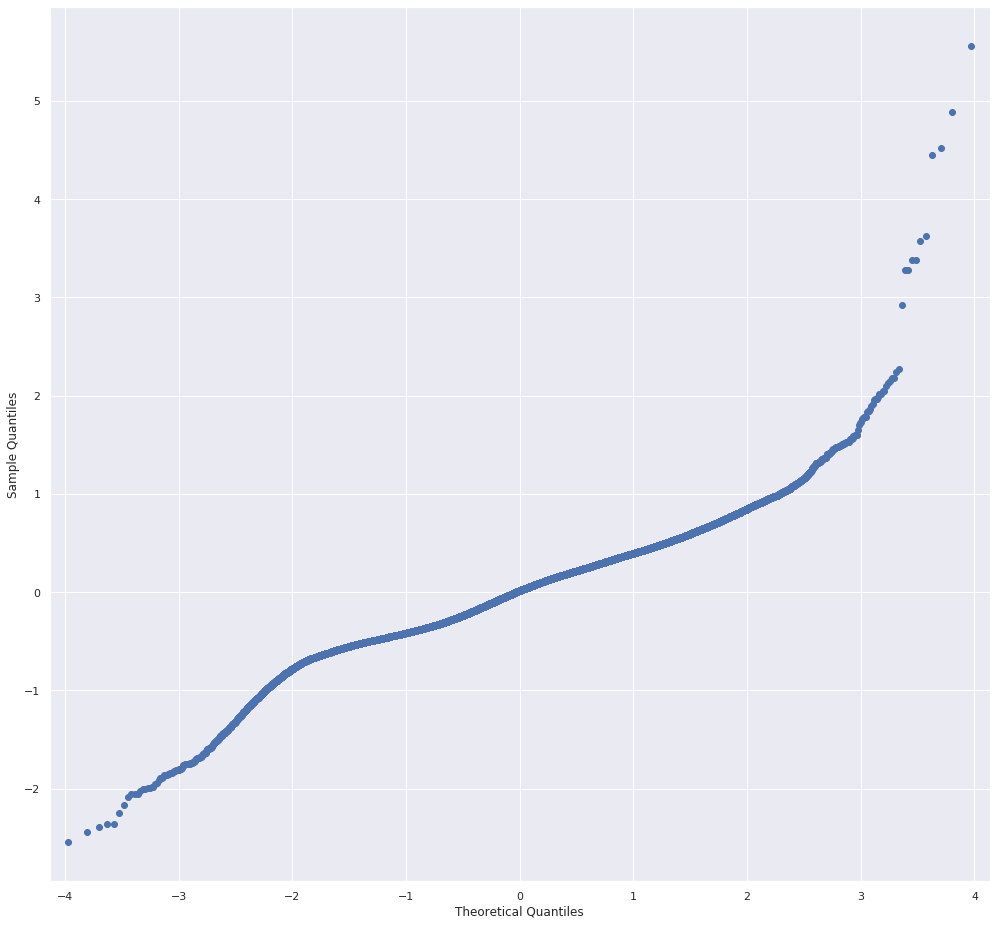

In [23]:
cm_functions.lr_qq(fm)

Visually our qq plot is much more linear than our initial model, although it is not completely linear. 

##### 3. Normality of Errors
Linear regression assumes that the residuals are normally distributed.The quantitative Jarque-Bera test is performed automatically as part of the model summary output, labeled Jarque-Bera (JB) and Prob(JB). 

* Jarque-Bera (JB):           1008.174
* Prob(JB):                   1.20e-219

While this test shows violation of this assumption given the low Prob(JB), we are much closser to meeting this assumption

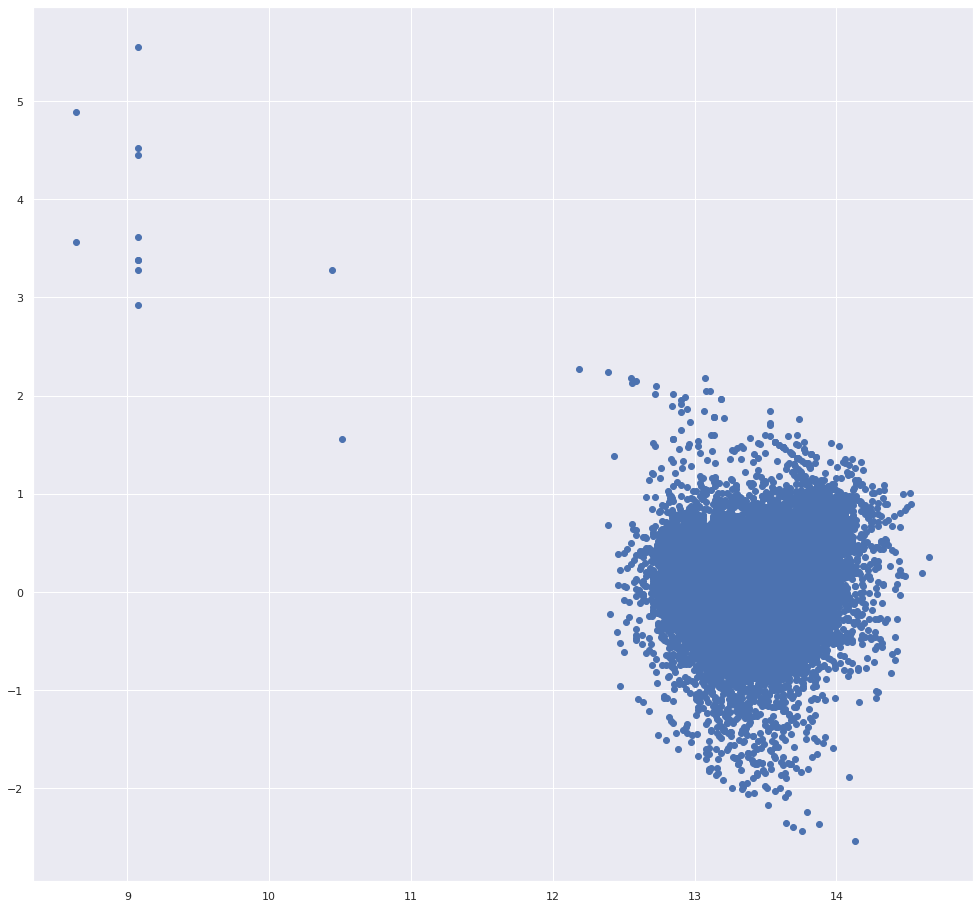

In [24]:
cm_functions.lr_homoscad(fm, fmodel_df)

While this test shows violation of this assumption given the low Prob(JB), we are much closser to meeting this assumption

##### 5.	Multicollinearity
This assumption is that the independent variables must not be too collinear. Using a VIF computation we can test this assumption. We have only one independent variable here, we do not need to check this.

In [25]:
cm_functions.lr_independence(fmodel_df)

        VIF           feature
0  2.265426  LogSqFtTotLiving
1  2.256894     LogPorchTotal
2  1.015334     is_waterfront


VIF needs to be smaller than 5.


# III. Recommendations for Real World Application

Because our model generally meets the assumptions needed for a linear regression model, this model shows evidence that a representative model of 2019 King County Housing sales could possibly be constructed through further feature engineering and an improved R squared value. Were you to use this model to get a home price using the feature data of the listing, you could compare this theoretical price to the actual list price or sale price to see whether it might have been undervalued or overvalued. 

# IV. Next Steps

When it comes to analyzing the the significance of the porch data we can delve deeper into making a stronger correlation. Also, when looking at the square footage of a closed versus open porch there may be some correlations to sale price. Given time I beleive this could yield fruitful results. 

With the waterfront feature, more investigation could be done into sale prices historically to get more samples for the different locations of water. The number of samples varied greatly with 2019 data per location. 

Finally, further feature engineering can be done and added to the model to raise the rsquared value and obtain a more accurate model, while maintaining assumptions. 